In [ ]:
import torch
import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import ToSLIC

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import skimage as ski

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 28)
RAG with 64 nodes and 179 edges


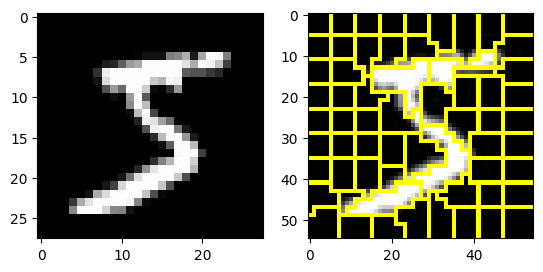

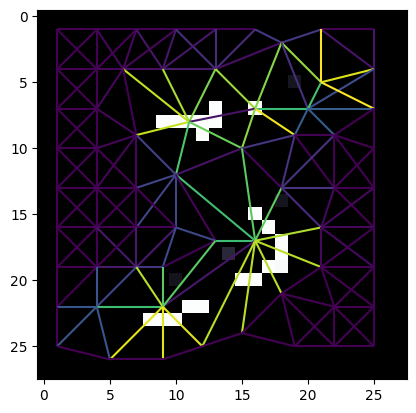

In [ ]:
i = ds.data[0].numpy()
print(i.shape)
segments = slic(i, n_segments=75, compactness=0.1)
g = ski.future.graph.rag_mean_color(i, segments)
print(g)

fig, axs = plt.subplots(1,2)
axs[0].imshow(i, "gray")
segmented_img = ski.segmentation.mark_boundaries(i, segments, mode="subpixel")
axs[1].imshow(segmented_img, "gray")
ski.future.graph.show_rag(segments, g, ski.color.gray2rgb(i), edge_cmap='viridis')


In [ ]:
class SuperPixelGraphMNIST(InMemoryDataset):
    def __init__(self, n_segments = 75, compactness = 0.1, train= True, root = None, transform = None, pre_transform = None, pre_filter = None):
        super().__init__(root, transform, pre_transform, pre_filter)
    
    def loadMNIST(self, n_segments, compactness, train):
        mnist = datasets.MNIST(root='./data', train=train, download=True, transform=T.ToTensor())
        data_list = []
        for img in mnist.data:
            s = slic(img, n_segments, compactness)
            

In [ ]:
transform = T.Compose([T.ToTensor(), ToSLIC(n_segments=75)])
ds = datasets.MNIST(root='./data', train=True, download=True, transform=T.ToTensor())
ds_not_seg = datasets.MNIST(root='./data', train=True, download=True, transform=T.ToTensor())
print(ds.data.shape)

torch.Size([60000, 28, 28])


None


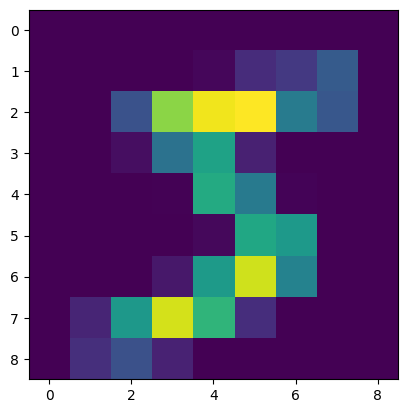

In [ ]:
print(ds[0][0].edge_index)
i  = ds[0][0].x.view([9,9])
plt.imshow(i)
